In [ ]:
!pip3 install pickle5 scattertext wordcloud nltk pymorphy2 emoji


In [ ]:
from google.colab import output
from google.colab import files
import zipfile
import io
output.enable_custom_widget_manager()
uploaded = files.upload()
data = zipfile.ZipFile(io.BytesIO(uploaded['data.zip']), 'r')
data.extractall()

Saving data.zip to data (2).zip


# Лекция №3
# Тема: Линейные модели классификации (бинарная и многоклассовая). Логистическая регрессия и метод опорных векторов. 


В данной задаче нужно спрогнозировать семантику отзыва клиента с платформы Delivery Club, ответить на вопрос отрицательный или положительный отзыв оставил клиент, применяя логистическую регрессию. Это очень важная задача для компаний, так можно узнавать, что не нравится клиентам, делать выводы и улучшать сервис.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
import json
import warnings
from tqdm import tqdm
from collections import Counter
from IPython.display import IFrame, Math
import IPython

warnings.filterwarnings("ignore")

In [ ]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()
import plotly.io as pio
pio.renderers.default = "colab"

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import scattertext as st
from wordcloud import WordCloud
import nltk
import re
import emoji
from nltk.stem.snowball import RussianStemmer
from nltk.corpus import stopwords
nltk.download('stopwords');
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
rus_stem = RussianStemmer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Изучение данных

In [ ]:
import pickle5 as pickle
with open('data/reviews_tonality_X.pkl', "rb") as fh:
  X = pickle.load(fh)
with open('data/reviews_tonality_y.pkl', "rb") as fh:
  y = pickle.load(fh)
X['tonality'] = y

In [ ]:
X

,id,text,tonality
0,0,"Заказ привезли на пол часа позже времени. Но, ...",positive
1,1,"настолько острое , что не возможно есть. один ...",negative
2,2,Привезли с опозданием на 50 минут \nВсе ледяно...,negative
3,3,заказываю не в первый раз — доволен каждым: од...,positive
4,4,на 3 порции роллов 2 соевых соуса. плохо,negative
...,...,...,...
99995,99995,Пицца была холодной и сухой. Раньше пицца с ко...,negative
99996,99996,"Фунчоза была пропавшая, пахла как капуста кваш...",negative
99997,99997,не положили один воппер джуниор с сыром и беконом,negative
99998,99998,Не положили салфетки,positive


In [ ]:
X['tonality'].value_counts()

positive    52697
negative    47303
Name: tonality, dtype: int64

Количество отзывов положительных и отрицательных примерно одинаково, выборки достаточно хорошо сбалансированны

In [ ]:
df = X.copy()

In [ ]:
df = df.iloc[:10000].copy()

In [ ]:
df.iloc[30:40]

,id,text,tonality
30,30,неправильно приносили,positive
31,31,Невкусная еда в целом,negative
32,32,Спасибо большое,positive
33,33,"Нам нравится, да разок забыли палочки.... Быва...",positive
34,34,Всё очень вкусно,positive
35,35,супер солёная курица,negative
36,36,Манты 🔥🔥🔥,positive
37,37,"Шикарные блюда, очень вкусное все! привезли бы...",positive
38,38,"заказ приехал вовремя, горячий. осетинский вку...",negative
39,39,Не положили 2 чизбургера,negative


### Нормализация и очистка данных

Стоп-слово — это часто используемое слово (например, "в", "от", "с", "до"), которое не придаёт никакого смысла в предложении/тексте и которые можно удалить. 


In [ ]:
stop_words = set(stopwords.words('russian'))
stop_words = stop_words - set(['не', 'хорошо', 'лучше', 'можно', 'много', 'ничего', 'больше'])
print(stop_words)

{'здесь', 'никогда', 'он', 'свою', 'моя', 'а', 'раз', 'иногда', 'где', 'ты', 'этот', 'всего', 'разве', 'том', 'как', 'ему', 'три', 'между', 'чтоб', 'они', 'почти', 'даже', 'тот', 'об', 'себя', 'хоть', 'надо', 'над', 'мне', 'всех', 'куда', 'ним', 'еще', 'все', 'без', 'ну', 'будто', 'ей', 'ж', 'эту', 'ни', 'чем', 'нельзя', 'теперь', 'от', 'же', 'того', 'меня', 'более', 'в', 'через', 'него', 'у', 'наконец', 'потом', 'с', 'впрочем', 'тоже', 'опять', 'там', 'был', 'ли', 'его', 'тут', 'нас', 'будет', 'потому', 'ведь', 'нее', 'да', 'так', 'она', 'вам', 'кто', 'какой', 'вы', 'со', 'есть', 'мы', 'нет', 'то', 'была', 'другой', 'какая', 'было', 'или', 'сейчас', 'когда', 'перед', 'всю', 'при', 'к', 'что', 'один', 'после', 'уже', 'тем', 'уж', 'на', 'совсем', 'чуть', 'во', 'эти', 'сам', 'я', 'за', 'два', 'чтобы', 'до', 'мой', 'и', 'если', 'тебя', 'них', 'по', 'этой', 'всегда', 'конечно', 'чего', 'быть', 'нибудь', 'им', 'для', 'себе', 'их', 'этого', 'были', 'ее', 'вот', 'такой', 'может', 'вдруг', 'ва

- Лемматиза́ция — процесс приведения словоформы к лемме — её нормальной (словарной) форме.
- Сте́мминг (англ. stemming — находить происхождение) — это процесс нахождения основы слова для заданного исходного слова.



<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1LUY_XdWy5pX4ej3xcfTYpFCnhpUfp6l8" width="700">
</p>

In [ ]:
def clean_text(text):
    # очищаем от некоторых символов
    text = re.sub("\'", "", text)
    # в отзывах много emojiу, переводим их в текст
    text = emoji.demojize(text, delimiters=(' ', ' '))
    # оставляем только буквы, нижние подчеркивания и тире
    text = re.sub("[^а-яА-Яa-zA-Z\-\_ё]"," ",text) 
    # удаляем лишние пробелы
    text = ' '.join(text.split())
    # приводим к нижнему регистру
    text = text.lower()
    return text

# def lemmatization_spacy(text):
#     doc = nlp(text)
#     tokens = [token.lemma_ for token in doc]
#     return " ".join(tokens)

def lemmatization_morph(text):
    '''Функция для леммантизации слов'''
    lemmatize_text = [morph.parse(w)[0].normal_form for w in text.split()]
    return ' '.join(lemmatize_text)

def remove_stopwords(text):
    '''Функция для удаления стоп-слов'''
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

def stemmer(text):
    '''Функция для стемминга слов'''
    stemmer_text = [rus_stem.stem(w) for w in text.split()]
    return ' '.join(stemmer_text)

In [ ]:
s = df.iloc[37]['text']
s1 = clean_text(s)
print(s, s1, sep='\n')

Шикарные блюда, очень вкусное все! привезли быстро, мы в восторге. Спасибо!
шикарные блюда очень вкусное все привезли быстро мы в восторге спасибо


In [ ]:
s2 = remove_stopwords(s1)
print(s1, s2, sep='\n')

шикарные блюда очень вкусное все привезли быстро мы в восторге спасибо
шикарные блюда очень вкусное привезли быстро восторге спасибо


In [ ]:
s3 = lemmatization_morph(s2)
print(s2, s3, sep='\n')

шикарные блюда очень вкусное привезли быстро восторге спасибо
шикарный блюдо очень вкусный привезти быстро восторг спасибо


In [ ]:
s = df.iloc[36]['text']
s1 = lemmatization_morph(remove_stopwords(clean_text(s)))
print(s, s1, sep='\n')

Манты 🔥🔥🔥
манта fire fire fire


In [ ]:
%%time
# получим размер каждого отзыва
df['len_text'] = df['text'].astype(str).apply(len)
# произведем очистку отзывов
df['clean_text'] = df['text'].apply(lambda x: clean_text(x))
# произведем очистку стоп-слов
df['clean_text_stop_words'] = df['clean_text'].apply(
    lambda x: remove_stopwords(x))
# сделаем леммантизацию
df['clean_text_lemmatize'] = df['clean_text_stop_words'].apply(
    lambda x: lemmatization_morph(x))

CPU times: user 23.6 s, sys: 80.2 ms, total: 23.7 s
Wall time: 23.7 s


### Проанализируем некоторые особенности наших данных

In [ ]:
Counter([1, 2, 3, 4, 4, 5, 5, 5, 5])

Counter({1: 1, 2: 1, 3: 1, 4: 2, 5: 4})

In [ ]:
def freq_words(x, n=10):
    words_df = pd.DataFrame(dict(Counter(x.str.cat(sep=' ').split())).items(), columns=['word', 'count'])
    words_df = words_df.nlargest(columns="count", n=n) 
    plt.figure(figsize=(15,10)) 
    ax = sns.barplot(data=words_df, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

Посмотрим на самые частотные слова до леммантизации и удаления стоп-слов

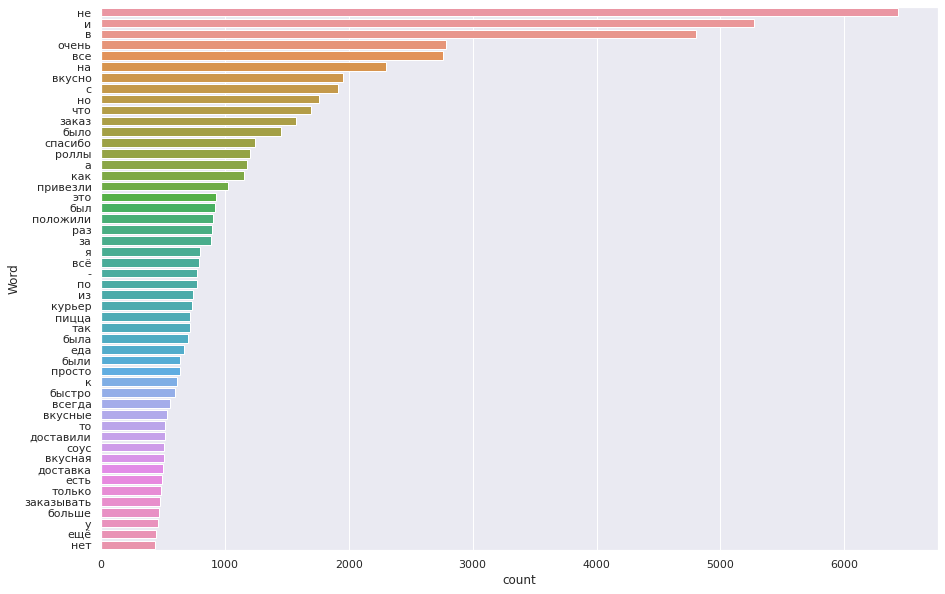

In [ ]:
freq_words(df['clean_text'], 50)

Посмотрим на самые частотные слова после леммантизации и удалении стоп-слов

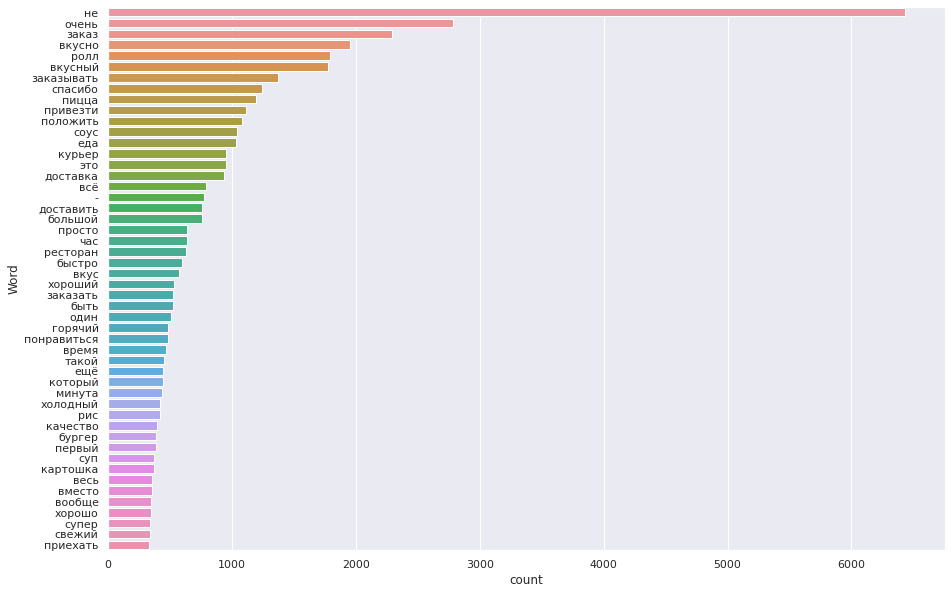

In [ ]:
freq_words(df['clean_text_lemmatize'], 50)

Посмотрим также на распределение длины отзыва, видим, что медиана равна 59 символам

In [ ]:
fig1 = px.histogram(df, x="len_text", marginal="box", nbins=1000, template='plotly_dark')
fig1.update_layout(bargap=0.1)
fig1.update_layout(
    title={
        'text': 'Text Length distribution',
        'y':0.95,
        'x':0.45,
        'xanchor': 'center',
        'yanchor': 'top'})
fig1.update_xaxes(range=[-20, 500], row=1, col=1)
fig1.update_xaxes(showgrid=True, gridwidth=1)
fig1.show()


### Облако слов

Облако слов — это метод визуализации часто встречающихся слов в тексте, где размер слов отражает их частоту. Каждое слово в этом облаке имеет переменный размер шрифта и цветовой тон. Таким образом, это представление помогает определить известные слова. Чем больше размер шрифта слова, тем выше его значимость по сравнению с другими словами в кластере. Количество слов играет важную роль при создании облака слов. Много слов не всегда означает лучшее облако слов, поскольку оно становится загромождённым и трудным для чтения. Облако слов всегда должно быть семантически значимым и представлять то, для чего оно предназначено. Хотя существуют разные способы создания облаков слов, но наиболее широко используемый тип — это использование частоты слов в корпусе. История облаков слов восходит к 1976 году, когда американский социальный психолог Стэнли Милгрэм провёл психологическое исследование и расспросил людей о местах из Парижа. Основная идея заключалась в том, чтобы построить ментальную карту Парижа, когда людей спрашивали о городе. Он проанализировал и нарисовал карту на основе ответов, полученных от людей, и сохранил больший размер шрифта для часто получаемых ответов.



In [ ]:
def plotWordCloud(text_pd_series, colormap=None):
    # переводим все предложения в список слов
    series_words = text_pd_series.str.cat(sep=' ')
    wordcloud = WordCloud(max_words=1000, width=1600, height=800,
                          background_color='white', colormap=colormap).generate(series_words)
    # визуализируем словарные облака
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

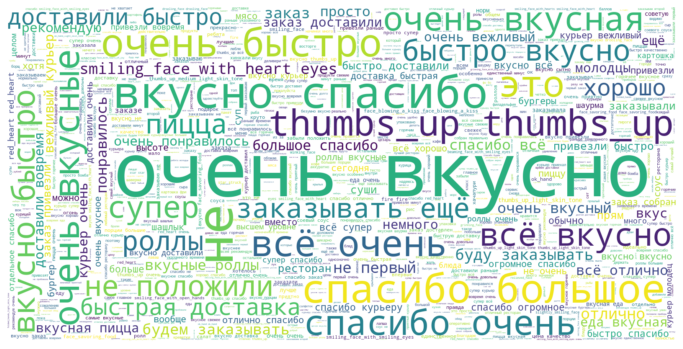

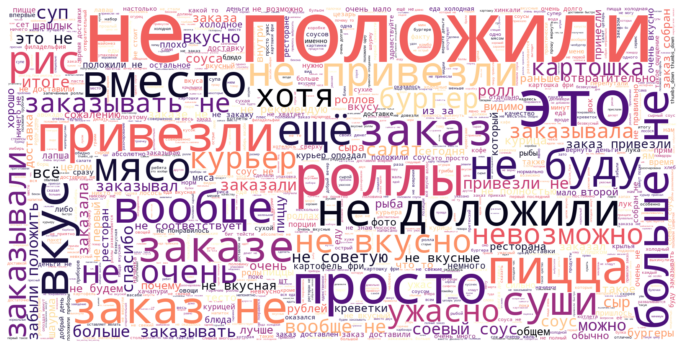

In [ ]:
plotWordCloud(df[df['tonality'] == 'positive']['clean_text_stop_words'])
plotWordCloud(df[df['tonality'] == 'negative']['clean_text_stop_words'], colormap='magma')


Видим, как явно выделяются самые важные слова для отрицательных («не положили», «не вкусно») и положительных отзывов («спасибо большое», «очень вкусно»).

### Scattertext *

Изучение данных с помощью библиотеки scattertext

In [ ]:
df['parse'] = df.text.apply(st.whitespace_nlp_with_sentences)
corpus = st.CorpusFromParsedDocuments(
    df.sample(min(df.shape[0], 50000)), category_col='tonality', parsed_col='parse',
).build().get_unigram_corpus()
html = st.produce_scattertext_explorer(
    corpus,
    category='positive',
    category_name='positive',
    not_category_name='negative',
    minimum_term_frequency=5,
    max_terms=2000,
    background_color='white',
    pmi_threshold_coefficient=0,
    width_in_pixels=1000,
#     transform=st.Scalers.dense_rank
)
file_name = './reviews.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IPython.display.HTML(filename='./reviews.html')

Output hidden; open in https://colab.research.google.com to view.

Подробнее об этой визуализации можно узнать здесь 
https://nbviewer.org/github/JasonKessler/GlobalAI2018/blob/master/notebook/Scaled-F-Score-Explanation.ipynb


## Построение модели

### TF-IDF

TF-IDF (от англ. TF — term frequency, IDF — inverse document frequency) — это один способ преобразования текстовых данных в числовую форму, это некая метрика, используемая для оценки важности слова в контексте документа (предложения), являющегося частью коллекции документов или корпуса (текста). Вес некоторого слова пропорционален частоте употребления этого слова в документе (предложении) и обратно пропорционален частоте употребления слова во всех документах коллекции (тексте).


<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1XD-FThp2sjuyntVO51RyC3JNzNeX9NVB" width="700">
</p>


In [ ]:
documents = ["Я люблю яблоки и груши",
    "Я люблю яблоки, лимоны и апельсины",
    "Я люблю киви, груши и апельсины"]

In [ ]:
def compute_tf(text):
    #На вход берём текст в виде списка (list) слов
    #Считаем частотность всех терминов во входном массиве с помощью 
    #метода Counter библиотеки collections
    tf_text = Counter(text)
    L = len(text)
    for i in tf_text:
        #для каждого слова в tf_text считаем TF путём деления
        #встречаемости слова на общее количество слов в тексте
        tf_text[i] = tf_text[i]/L
    #возвращаем объект типа Counter c TF всех слов текста
    return tf_text

def compute_idf(word, corpus):
    #на вход берётся слово, для которого считаем IDF
    #и корпус документов в виде списка списков слов
    #количество документов, где встречается искомый термин
    #считается как генератор списков
    return np.log(len(corpus)/sum([1.0 for i in corpus if word in i.split()]))

def compute_tfidf(corpus):
    documents_list = []
    corpus = [clean_text(i) for i in corpus]
    for text in corpus:
        tf_idf_dictionary = {}
        computed_tf = compute_tf(text.split())
        for word in computed_tf:
            tf_idf_dictionary[word] = computed_tf[word] * compute_idf(word, corpus)
        documents_list.append(tf_idf_dictionary)
    return documents_list

In [ ]:
compute_tfidf(documents)

[{'груши': 0.08109302162163289,
  'и': 0.0,
  'люблю': 0.0,
  'я': 0.0,
  'яблоки': 0.08109302162163289},
 {'апельсины': 0.06757751801802739,
  'и': 0.0,
  'лимоны': 0.1831020481113516,
  'люблю': 0.0,
  'я': 0.0,
  'яблоки': 0.06757751801802739},
 {'апельсины': 0.06757751801802739,
  'груши': 0.06757751801802739,
  'и': 0.0,
  'киви': 0.1831020481113516,
  'люблю': 0.0,
  'я': 0.0}]

In [ ]:
(1/5) * (np.log(3/2))

0.08109302162163289

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(documents)
print(x.toarray())
print(vectorizer.vocabulary_)

[[0.         0.61980538 0.         0.         0.48133417 0.61980538]
 [0.4804584  0.         0.         0.63174505 0.37311881 0.4804584 ]
 [0.4804584  0.4804584  0.63174505 0.         0.37311881 0.        ]]
{'люблю': 4, 'яблоки': 5, 'груши': 1, 'лимоны': 3, 'апельсины': 0, 'киви': 2}


Отличия от нашего результат в том, что в TfidfVectorizer применяются сглаживания и немного другие нормировки, но смысл не меняется.

In [ ]:
vectorizer = TfidfVectorizer(norm=False)
x = vectorizer.fit_transform(documents)
print(x.toarray())
print(vectorizer.vocabulary_)

[[0.         1.28768207 0.         0.         1.         1.28768207]
 [1.28768207 0.         0.         1.69314718 1.         1.28768207]
 [1.28768207 1.28768207 1.69314718 0.         1.         0.        ]]
{'люблю': 4, 'яблоки': 5, 'груши': 1, 'лимоны': 3, 'апельсины': 0, 'киви': 2}


In [ ]:
(1/5) * (np.log(3/2))

In [ ]:
1 * (np.log((3+1)/(2+1)) + 1)

1.2876820724517808

Сделаем разбиение наших данных на тест, валидацию и контроль в соотношении 80/10/10 с помощью train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
x = df.clean_text_lemmatize
y = df.tonality.apply(lambda x: 1 if x=='positive' else 0)
x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(x, y, test_size=.2, random_state=147)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.5, random_state=147)


### Выбор лучшей модели

In [ ]:
n_features = [5_000, 10_000, 20_000, 50_000, 100_000, 250_000, 400_000] # будем проверять модели с таким количеством признаков (берутся самые частотные слова)


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def model_evaluate(model, X_test):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred, digits=3))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.3%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.show()
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

def nfeature_accuracy_checker(vectorizer, classifier,
                              n_features=n_features, stop_words=None,
                              classifier_name='',
                              ngram_range=(1, 1)):
    result = []
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        vectorizer.fit(x_train)
        X_train = vectorizer.transform(x_train)
        X_test  = vectorizer.transform(x_test)
        classifier.fit(X_train, y_train)
        print(vectorizer, classifier)
        print("\n")
        accuracy = model_evaluate(classifier, X_test)
        result.append((n, accuracy, ngram_range, classifier_name))
    return result



N-грамма — последовательность из n элементов, например, последовательность из нескольких слов. Последовательность из двух последовательных элементов часто называют биграмма, последовательность из трёх элементов называется триграмма. Не менее четырёх и выше элементов обозначаются как N-грамма, N заменяется на количество последовательных элементов.

In [ ]:
from nltk import ngrams
sentence = 'this is a foo bar sentences and i want to ngramize it'
n = 3
tgrams = ngrams(sentence.split(), n)
for grams in tgrams:
  print(grams)

('this', 'is', 'a')
('is', 'a', 'foo')
('a', 'foo', 'bar')
('foo', 'bar', 'sentences')
('bar', 'sentences', 'and')
('sentences', 'and', 'i')
('and', 'i', 'want')
('i', 'want', 'to')
('want', 'to', 'ngramize')
('to', 'ngramize', 'it')


In [ ]:
tvec = TfidfVectorizer()

TfidfVectorizer(max_features=5000) LinearSVC()


              precision    recall  f1-score   support

           0      0.869     0.921     0.894      4709
           1      0.926     0.876     0.900      5291

    accuracy                          0.897     10000
   macro avg      0.897     0.899     0.897     10000
weighted avg      0.899     0.897     0.897     10000



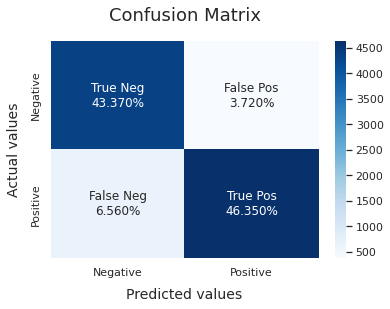

TfidfVectorizer(max_features=10000) LinearSVC()


              precision    recall  f1-score   support

           0      0.869     0.921     0.894      4709
           1      0.926     0.876     0.901      5291

    accuracy                          0.898     10000
   macro avg      0.898     0.899     0.898     10000
weighted avg      0.899     0.898     0.898     10000



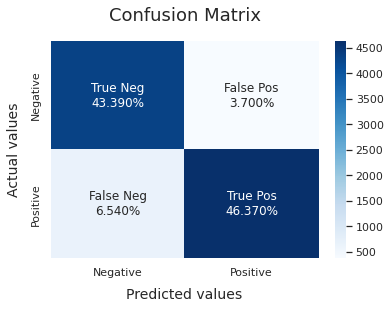

TfidfVectorizer(max_features=20000) LinearSVC()


              precision    recall  f1-score   support

           0      0.867     0.921     0.894      4709
           1      0.926     0.875     0.900      5291

    accuracy                          0.897     10000
   macro avg      0.897     0.898     0.897     10000
weighted avg      0.898     0.897     0.897     10000



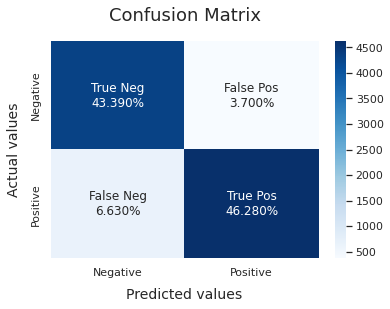

TfidfVectorizer(max_features=50000) LinearSVC()


              precision    recall  f1-score   support

           0      0.868     0.922     0.894      4709
           1      0.926     0.875     0.900      5291

    accuracy                          0.897     10000
   macro avg      0.897     0.899     0.897     10000
weighted avg      0.899     0.897     0.897     10000



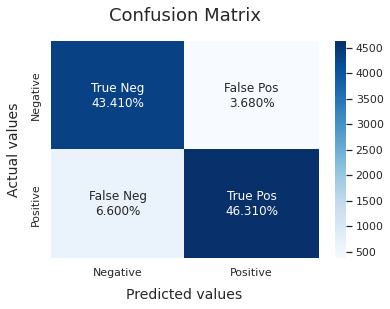

TfidfVectorizer(max_features=100000) LinearSVC()


              precision    recall  f1-score   support

           0      0.868     0.922     0.894      4709
           1      0.926     0.875     0.900      5291

    accuracy                          0.897     10000
   macro avg      0.897     0.899     0.897     10000
weighted avg      0.899     0.897     0.897     10000



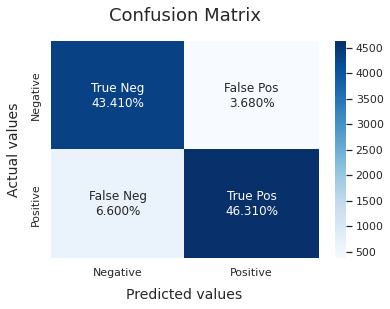

TfidfVectorizer(max_features=250000) LinearSVC()


              precision    recall  f1-score   support

           0      0.868     0.922     0.894      4709
           1      0.926     0.875     0.900      5291

    accuracy                          0.897     10000
   macro avg      0.897     0.899     0.897     10000
weighted avg      0.899     0.897     0.897     10000



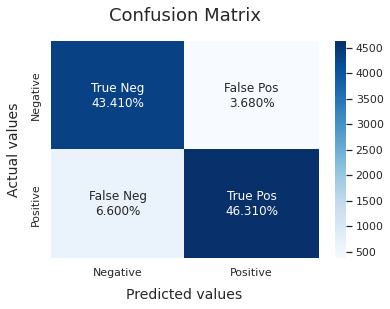

TfidfVectorizer(max_features=400000) LinearSVC()


              precision    recall  f1-score   support

           0      0.868     0.922     0.894      4709
           1      0.926     0.875     0.900      5291

    accuracy                          0.897     10000
   macro avg      0.897     0.899     0.897     10000
weighted avg      0.899     0.897     0.897     10000



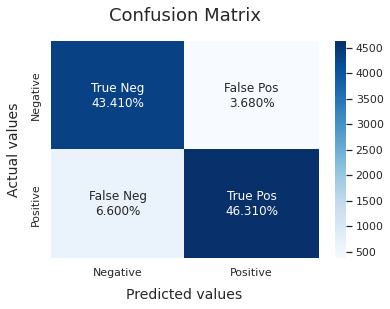

TfidfVectorizer(max_features=5000, ngram_range=(1, 2)) LinearSVC()


              precision    recall  f1-score   support

           0      0.877     0.931     0.903      4709
           1      0.935     0.884     0.908      5291

    accuracy                          0.906     10000
   macro avg      0.906     0.907     0.906     10000
weighted avg      0.907     0.906     0.906     10000



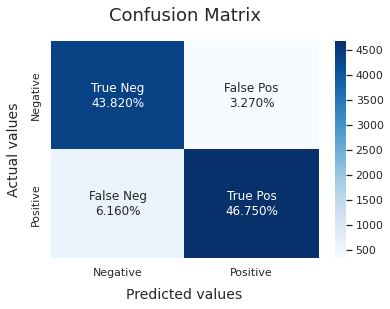

TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) LinearSVC()


              precision    recall  f1-score   support

           0      0.878     0.928     0.902      4709
           1      0.932     0.885     0.908      5291

    accuracy                          0.905     10000
   macro avg      0.905     0.906     0.905     10000
weighted avg      0.907     0.905     0.905     10000



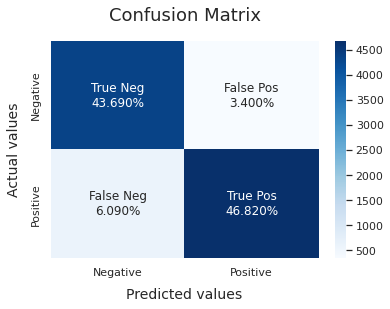

TfidfVectorizer(max_features=20000, ngram_range=(1, 2)) LinearSVC()


              precision    recall  f1-score   support

           0      0.877     0.925     0.900      4709
           1      0.929     0.884     0.906      5291

    accuracy                          0.903     10000
   macro avg      0.903     0.904     0.903     10000
weighted avg      0.905     0.903     0.903     10000



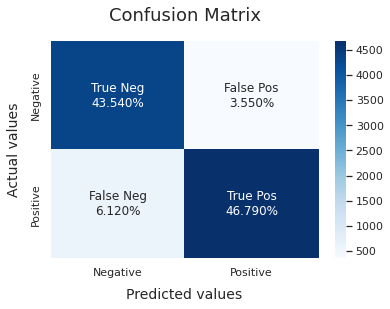

TfidfVectorizer(max_features=50000, ngram_range=(1, 2)) LinearSVC()


              precision    recall  f1-score   support

           0      0.878     0.927     0.902      4709
           1      0.931     0.886     0.908      5291

    accuracy                          0.905     10000
   macro avg      0.905     0.906     0.905     10000
weighted avg      0.906     0.905     0.905     10000



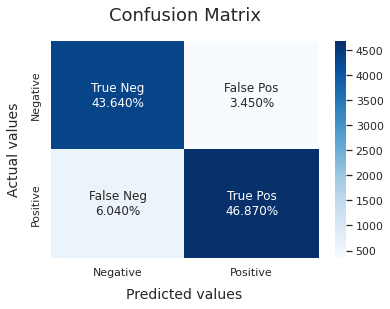

TfidfVectorizer(max_features=100000, ngram_range=(1, 2)) LinearSVC()


              precision    recall  f1-score   support

           0      0.879     0.929     0.903      4709
           1      0.934     0.886     0.909      5291

    accuracy                          0.906     10000
   macro avg      0.906     0.908     0.906     10000
weighted avg      0.908     0.906     0.906     10000



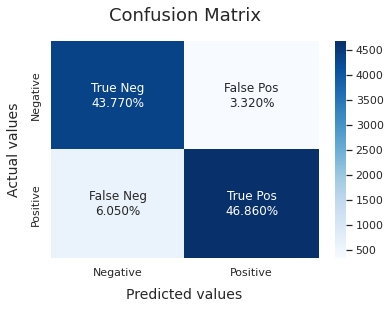

TfidfVectorizer(max_features=250000, ngram_range=(1, 2)) LinearSVC()


              precision    recall  f1-score   support

           0      0.878     0.936     0.906      4709
           1      0.940     0.884     0.911      5291

    accuracy                          0.909     10000
   macro avg      0.909     0.910     0.909     10000
weighted avg      0.911     0.909     0.909     10000



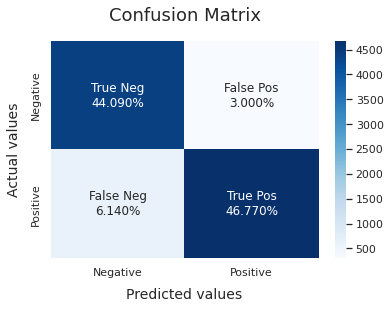

TfidfVectorizer(max_features=400000, ngram_range=(1, 2)) LinearSVC()


              precision    recall  f1-score   support

           0      0.876     0.938     0.906      4709
           1      0.941     0.882     0.911      5291

    accuracy                          0.908     10000
   macro avg      0.909     0.910     0.908     10000
weighted avg      0.910     0.908     0.908     10000



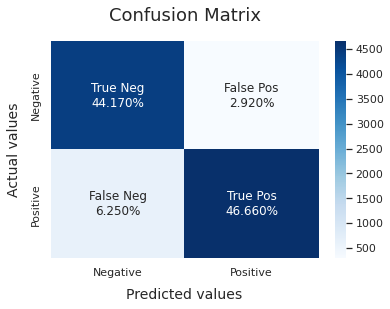

TfidfVectorizer(max_features=5000, ngram_range=(1, 3)) LinearSVC()


              precision    recall  f1-score   support

           0      0.877     0.929     0.903      4709
           1      0.933     0.885     0.908      5291

    accuracy                          0.905     10000
   macro avg      0.905     0.907     0.905     10000
weighted avg      0.907     0.905     0.906     10000



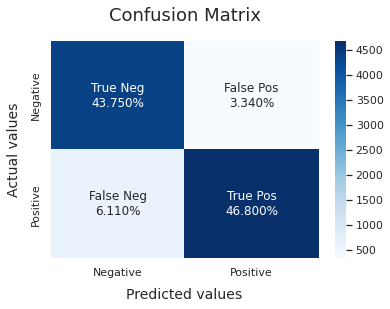

TfidfVectorizer(max_features=10000, ngram_range=(1, 3)) LinearSVC()


              precision    recall  f1-score   support

           0      0.876     0.927     0.901      4709
           1      0.932     0.883     0.907      5291

    accuracy                          0.904     10000
   macro avg      0.904     0.905     0.904     10000
weighted avg      0.905     0.904     0.904     10000



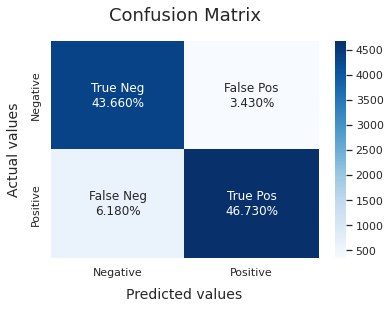

TfidfVectorizer(max_features=20000, ngram_range=(1, 3)) LinearSVC()


              precision    recall  f1-score   support

           0      0.879     0.925     0.901      4709
           1      0.930     0.887     0.908      5291

    accuracy                          0.905     10000
   macro avg      0.904     0.906     0.905     10000
weighted avg      0.906     0.905     0.905     10000



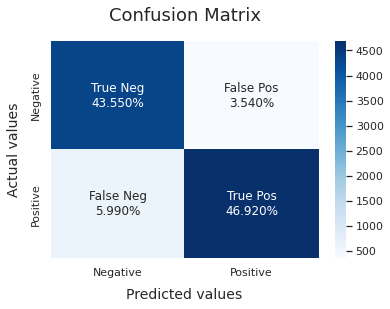

TfidfVectorizer(max_features=50000, ngram_range=(1, 3)) LinearSVC()


              precision    recall  f1-score   support

           0      0.877     0.923     0.899      4709
           1      0.928     0.884     0.906      5291

    accuracy                          0.903     10000
   macro avg      0.902     0.904     0.902     10000
weighted avg      0.904     0.903     0.903     10000



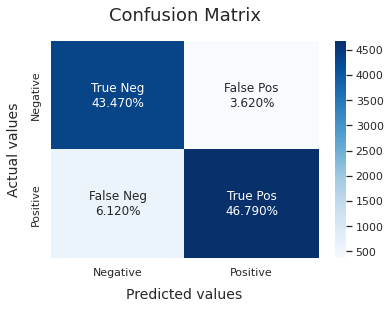

TfidfVectorizer(max_features=100000, ngram_range=(1, 3)) LinearSVC()


              precision    recall  f1-score   support

           0      0.879     0.926     0.902      4709
           1      0.931     0.886     0.908      5291

    accuracy                          0.905     10000
   macro avg      0.905     0.906     0.905     10000
weighted avg      0.906     0.905     0.905     10000



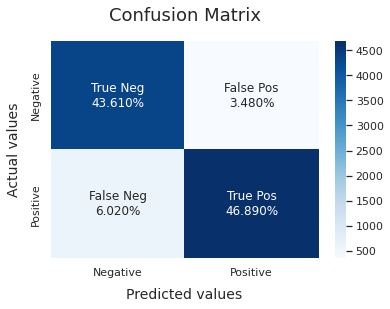

TfidfVectorizer(max_features=250000, ngram_range=(1, 3)) LinearSVC()


              precision    recall  f1-score   support

           0      0.878     0.930     0.903      4709
           1      0.934     0.885     0.909      5291

    accuracy                          0.906     10000
   macro avg      0.906     0.907     0.906     10000
weighted avg      0.908     0.906     0.906     10000



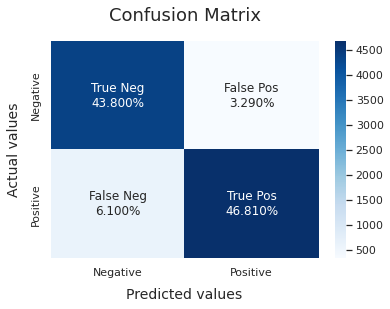

TfidfVectorizer(max_features=400000, ngram_range=(1, 3)) LinearSVC()


              precision    recall  f1-score   support

           0      0.877     0.934     0.905      4709
           1      0.938     0.883     0.910      5291

    accuracy                          0.907     10000
   macro avg      0.907     0.909     0.907     10000
weighted avg      0.909     0.907     0.907     10000



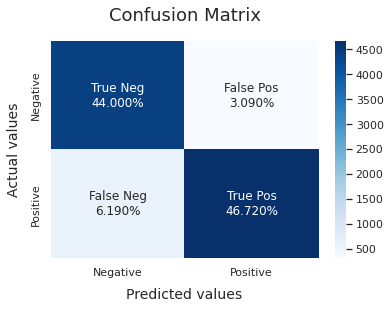

In [ ]:
# Модели LinearSVC
result_svc_ugt = nfeature_accuracy_checker(vectorizer=tvec, classifier=LinearSVC(),
                                           classifier_name='LinearSVC')

result_svc_bgt = nfeature_accuracy_checker(vectorizer=tvec, classifier=LinearSVC(),
                                           ngram_range=(1, 2), # включаем также биграммы
                                           classifier_name='LinearSVC')

result_svc_tgt = nfeature_accuracy_checker(vectorizer=tvec, classifier=LinearSVC(),
                                           ngram_range=(1, 3), # включаем также биграммы и триграммы
                                           classifier_name='LinearSVC')

TfidfVectorizer(max_features=5000) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.872     0.923     0.897      4709
           1      0.927     0.879     0.903      5291

    accuracy                          0.900     10000
   macro avg      0.900     0.901     0.900     10000
weighted avg      0.901     0.900     0.900     10000



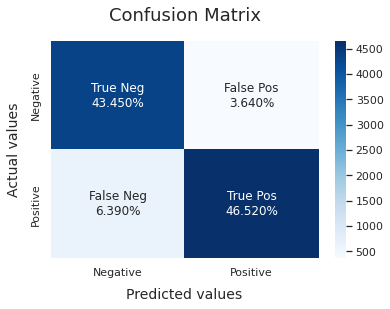

TfidfVectorizer(max_features=10000) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.872     0.923     0.897      4709
           1      0.928     0.879     0.903      5291

    accuracy                          0.900     10000
   macro avg      0.900     0.901     0.900     10000
weighted avg      0.901     0.900     0.900     10000



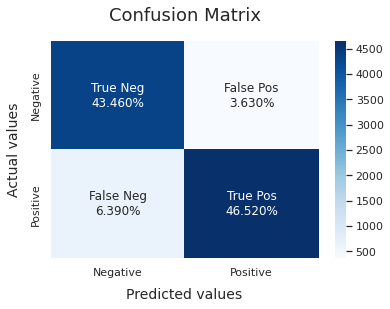

TfidfVectorizer(max_features=20000) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.872     0.923     0.897      4709
           1      0.928     0.879     0.903      5291

    accuracy                          0.900     10000
   macro avg      0.900     0.901     0.900     10000
weighted avg      0.901     0.900     0.900     10000



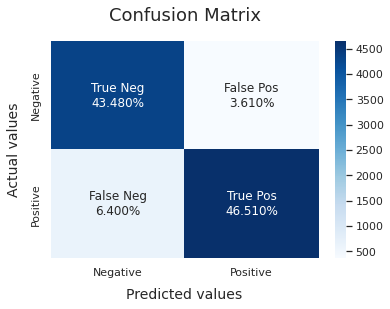

TfidfVectorizer(max_features=50000) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.872     0.924     0.897      4709
           1      0.928     0.880     0.903      5291

    accuracy                          0.900     10000
   macro avg      0.900     0.902     0.900     10000
weighted avg      0.902     0.900     0.901     10000



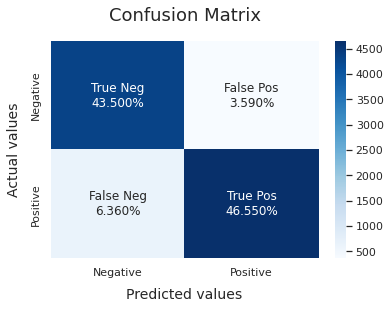

TfidfVectorizer(max_features=100000) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.872     0.924     0.897      4709
           1      0.928     0.880     0.903      5291

    accuracy                          0.900     10000
   macro avg      0.900     0.902     0.900     10000
weighted avg      0.902     0.900     0.901     10000



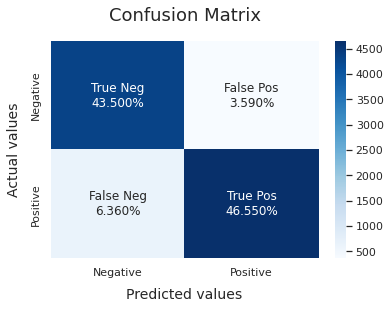

TfidfVectorizer(max_features=250000) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.872     0.924     0.897      4709
           1      0.928     0.880     0.903      5291

    accuracy                          0.900     10000
   macro avg      0.900     0.902     0.900     10000
weighted avg      0.902     0.900     0.901     10000



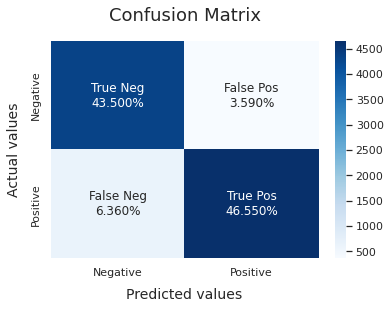

TfidfVectorizer(max_features=400000) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.872     0.924     0.897      4709
           1      0.928     0.880     0.903      5291

    accuracy                          0.900     10000
   macro avg      0.900     0.902     0.900     10000
weighted avg      0.902     0.900     0.901     10000



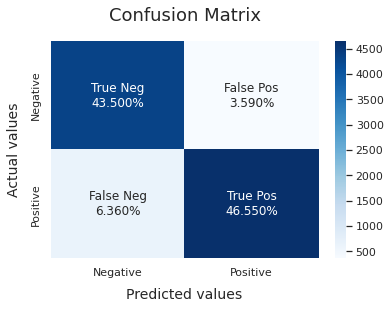

TfidfVectorizer(max_features=5000, ngram_range=(1, 2)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.879     0.936     0.907      4709
           1      0.939     0.885     0.912      5291

    accuracy                          0.909     10000
   macro avg      0.909     0.911     0.909     10000
weighted avg      0.911     0.909     0.909     10000



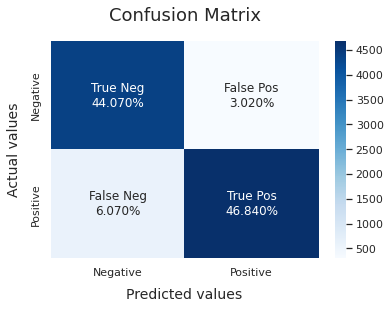

TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.879     0.938     0.908      4709
           1      0.941     0.885     0.912      5291

    accuracy                          0.910     10000
   macro avg      0.910     0.912     0.910     10000
weighted avg      0.912     0.910     0.910     10000



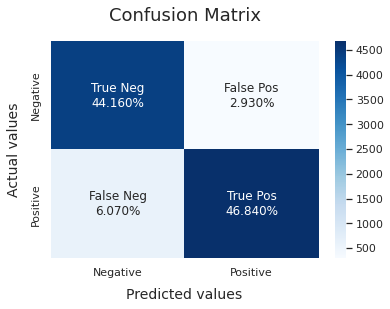

TfidfVectorizer(max_features=20000, ngram_range=(1, 2)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.879     0.939     0.908      4709
           1      0.942     0.885     0.912      5291

    accuracy                          0.910     10000
   macro avg      0.910     0.912     0.910     10000
weighted avg      0.912     0.910     0.910     10000



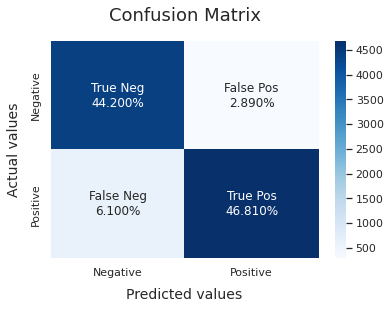

TfidfVectorizer(max_features=50000, ngram_range=(1, 2)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.877     0.940     0.907      4709
           1      0.943     0.882     0.912      5291

    accuracy                          0.909     10000
   macro avg      0.910     0.911     0.909     10000
weighted avg      0.912     0.909     0.910     10000



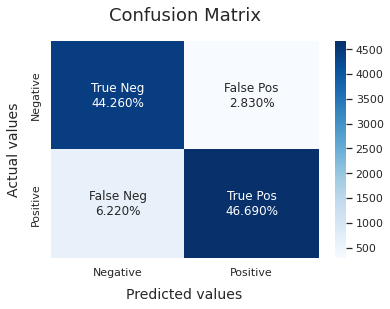

TfidfVectorizer(max_features=100000, ngram_range=(1, 2)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.876     0.941     0.907      4709
           1      0.944     0.881     0.911      5291

    accuracy                          0.909     10000
   macro avg      0.910     0.911     0.909     10000
weighted avg      0.912     0.909     0.909     10000



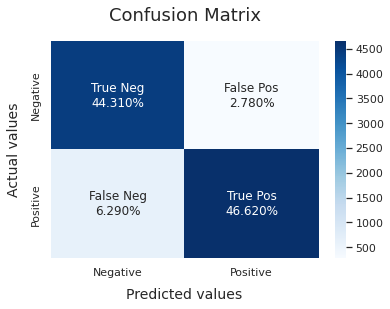

TfidfVectorizer(max_features=250000, ngram_range=(1, 2)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.873     0.941     0.906      4709
           1      0.944     0.878     0.910      5291

    accuracy                          0.908     10000
   macro avg      0.908     0.910     0.908     10000
weighted avg      0.910     0.908     0.908     10000



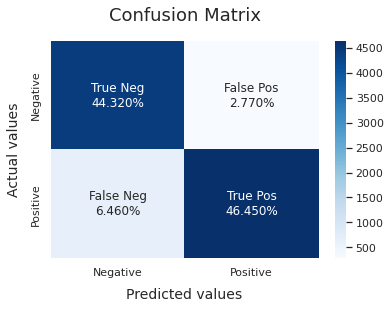

TfidfVectorizer(max_features=400000, ngram_range=(1, 2)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.872     0.941     0.906      4709
           1      0.944     0.878     0.910      5291

    accuracy                          0.908     10000
   macro avg      0.908     0.909     0.908     10000
weighted avg      0.910     0.908     0.908     10000



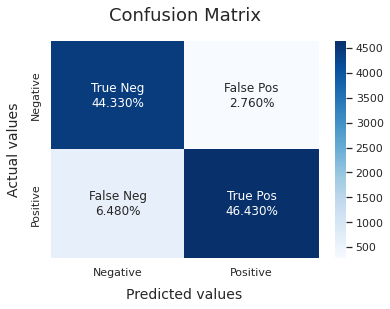

TfidfVectorizer(max_features=5000, ngram_range=(1, 3)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.879     0.935     0.906      4709
           1      0.939     0.885     0.911      5291

    accuracy                          0.909     10000
   macro avg      0.909     0.910     0.909     10000
weighted avg      0.910     0.909     0.909     10000



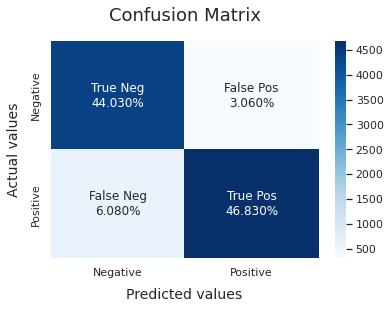

TfidfVectorizer(max_features=10000, ngram_range=(1, 3)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.880     0.937     0.908      4709
           1      0.940     0.886     0.913      5291

    accuracy                          0.910     10000
   macro avg      0.910     0.912     0.910     10000
weighted avg      0.912     0.910     0.910     10000



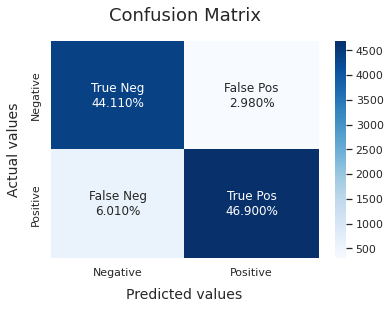

TfidfVectorizer(max_features=20000, ngram_range=(1, 3)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.879     0.939     0.908      4709
           1      0.942     0.885     0.912      5291

    accuracy                          0.910     10000
   macro avg      0.910     0.912     0.910     10000
weighted avg      0.912     0.910     0.910     10000



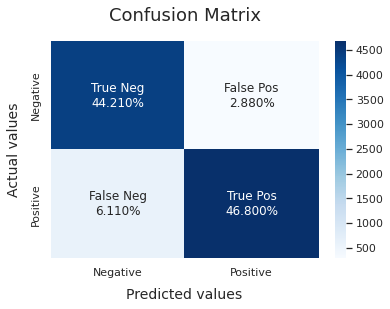

TfidfVectorizer(max_features=50000, ngram_range=(1, 3)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.877     0.939     0.907      4709
           1      0.942     0.882     0.911      5291

    accuracy                          0.909     10000
   macro avg      0.909     0.911     0.909     10000
weighted avg      0.911     0.909     0.909     10000



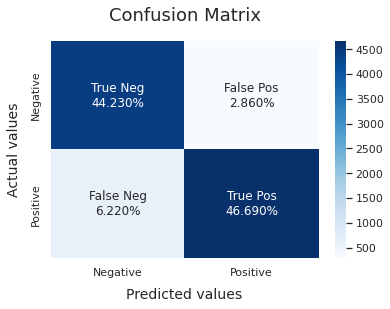

TfidfVectorizer(max_features=100000, ngram_range=(1, 3)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.876     0.940     0.907      4709
           1      0.943     0.882     0.912      5291

    accuracy                          0.909     10000
   macro avg      0.910     0.911     0.909     10000
weighted avg      0.912     0.909     0.909     10000



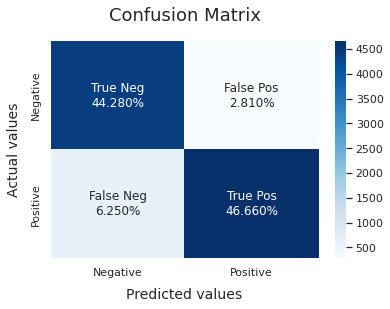

TfidfVectorizer(max_features=250000, ngram_range=(1, 3)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.874     0.941     0.906      4709
           1      0.943     0.880     0.910      5291

    accuracy                          0.908     10000
   macro avg      0.909     0.910     0.908     10000
weighted avg      0.911     0.908     0.908     10000



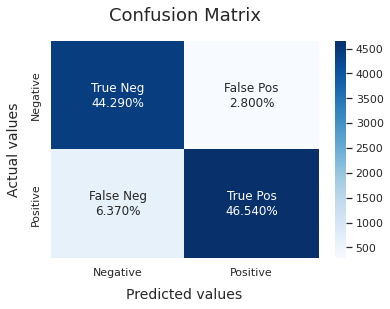

TfidfVectorizer(max_features=400000, ngram_range=(1, 3)) LogisticRegression(solver='liblinear')


              precision    recall  f1-score   support

           0      0.874     0.942     0.907      4709
           1      0.945     0.879     0.911      5291

    accuracy                          0.909     10000
   macro avg      0.909     0.911     0.909     10000
weighted avg      0.912     0.909     0.909     10000



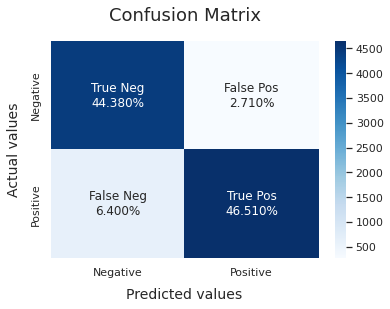

In [ ]:
# Модели LogisticRegression
result_lr_ugt = nfeature_accuracy_checker(vectorizer=tvec, classifier=LogisticRegression(solver='liblinear'),
                                               classifier_name='LogisticRegression')

result_lr_bgt = nfeature_accuracy_checker(vectorizer=tvec,
                                               classifier=LogisticRegression(solver='liblinear'),
                                               ngram_range=(1, 2), # включаем также биграммы
                                               classifier_name='LogisticRegression')

result_lr_tgt = nfeature_accuracy_checker(vectorizer=tvec,
                                               classifier=LogisticRegression(solver='liblinear'),
                                               ngram_range=(1, 3),# включаем также биграммы и триграммы
                                               classifier_name='LogisticRegression')


In [ ]:
results_plot = pd.DataFrame([j for i in [result_svc_ugt,
             result_svc_bgt, result_svc_tgt, result_lr_ugt, result_lr_bgt, result_lr_tgt] for j in i],
             columns=['nfeatures','accuracy', 'ngram_range', 'classifier_name'])




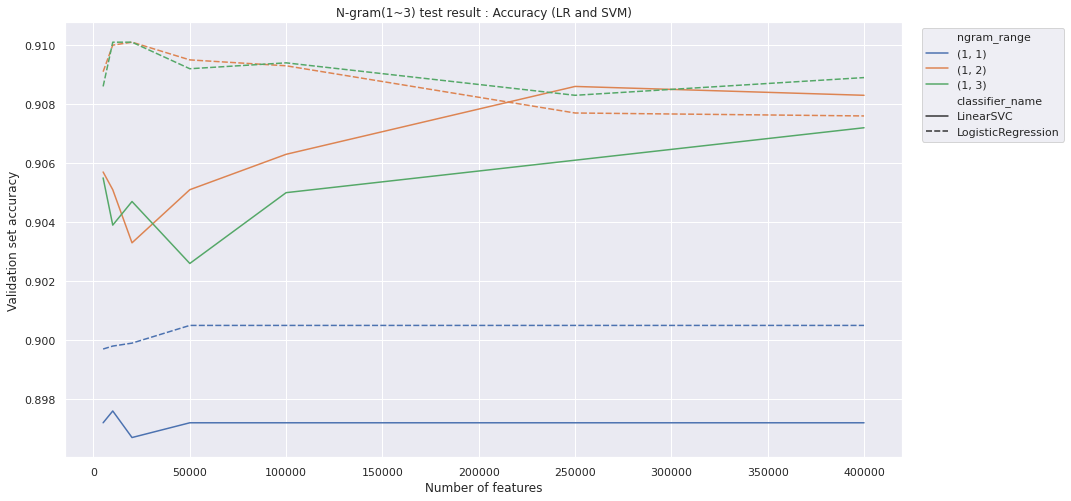

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=results_plot,
             x='nfeatures', y='accuracy',
             hue='ngram_range', style='classifier_name')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title("N-gram(1~3) test result : Accuracy (LR and SVM)")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.show()

На приведённой выше диаграмме мы видим, что включение биграмм и триграмм повышает производительность модели. Также логистическая регрессия c max_features = 10_000 и ngram_range=(1, 3) показала лучшие результаты, чем другие модели.


In [ ]:
vectorizer = TfidfVectorizer().set_params(max_features=10_000, ngram_range=(1, 3))
vectorizer.fit(x_train)
X_train = vectorizer.transform(x_train)
X_test  = vectorizer.transform(x_test)
classifier = LogisticRegression(solver='liblinear')
classifier.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

Посмотрим на такие метрики как ROC-AUC, построим Precision-Recall Curve

In [ ]:
y_score = classifier.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    height=700, template='plotly_dark')

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    height=700, template='plotly_dark')

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()